In [1]:
import torch
from src.Datasets import load
from torch.utils.data import DataLoader
from src.model import Conv_Net_FC_Dropout
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind


In [2]:
model = Conv_Net_FC_Dropout()
model.load_state_dict(torch.load('/home/julius/OOD/models/model3_drop_fc_0_5.pth'))
model.set_dropout(0.25)
model.to('cuda')
model.train()

Conv_Net_FC_Dropout(
  (convs): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
  )
  (fcs): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)

## MNIST

In [3]:
mnist = load('MNIST')(train=False)
mnist_loader = DataLoader(mnist, batch_size=1, shuffle=True)
d = {}
for i in range(10):
    d[i] = []
mnist_uncertainty = []
with torch.no_grad():
    for x,y in tqdm(mnist):
        x = x.repeat_interleave(128, dim=0)[:,None]
        x = x.to('cuda')
        out = model(x).cpu()
        mnist_uncertainty.append(out.std(dim=0).mean().item())
        d[y].append(out.std(dim=0).mean())


100%|██████████| 10000/10000 [00:16<00:00, 623.48it/s]


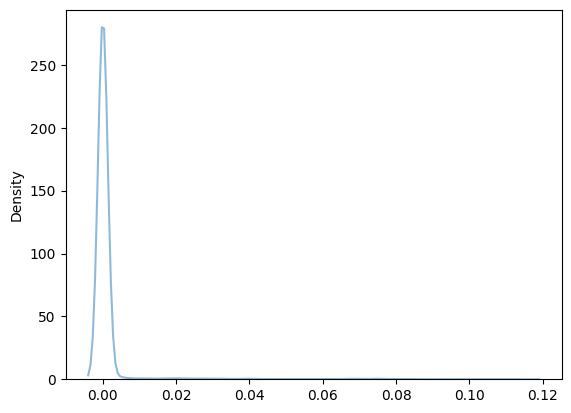

In [4]:
mnist_uncertainty = torch.tensor(mnist_uncertainty)
sns.kdeplot(mnist_uncertainty, alpha=0.5, label='MNIST')
plt.show()

In [5]:
mnist_df = pd.DataFrame()
for key in d.keys():
    df = pd.DataFrame({'Uncertainty': np.array(d[key]),'Class':np.repeat(key,len(d[key])).astype(str)})
    mnist_df = pd.concat([mnist_df, df], ignore_index=True)

<Axes: xlabel='Uncertainty', ylabel='Density'>

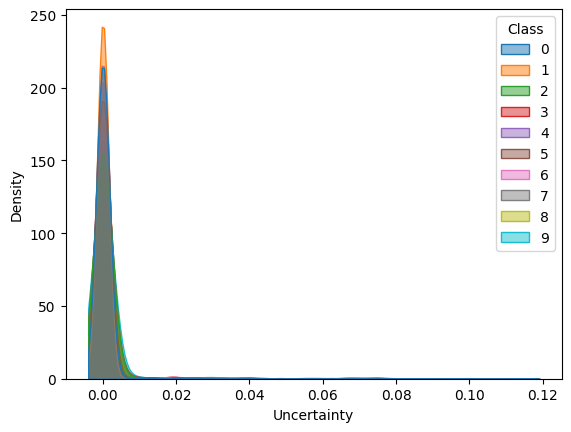

In [6]:
sns.kdeplot(data=mnist_df,x = 'Uncertainty', hue='Class', fill=True, common_norm=False, common_grid=True, alpha=0.5)

## CIFAR10

In [7]:
cifar10 = load('CIFAR10')(train=False)
cifar10_uncertainty = []
with torch.no_grad():
    for x,y in tqdm(cifar10):
        x = x.repeat_interleave(128, dim=0)[:,None]
        x = x.to('cuda')
        out = model(x).cpu()
        cifar10_uncertainty.append(out.std(dim=0).mean().item())

Files already downloaded and verified


100%|██████████| 10000/10000 [00:21<00:00, 459.92it/s]


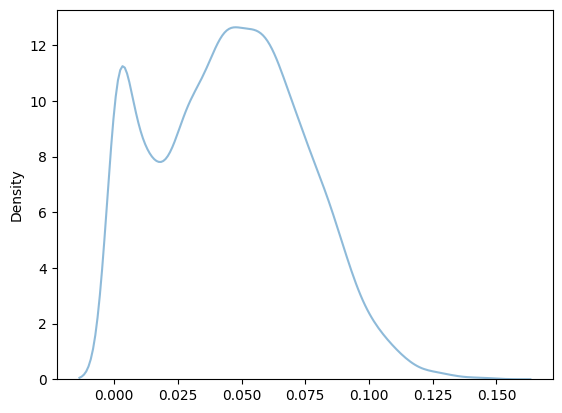

In [8]:
cifar10_uncertainty = torch.tensor(cifar10_uncertainty).clone().detach()
sns.kdeplot(cifar10_uncertainty,  alpha=0.5, label='CIFAR10')
plt.show()

## Classification problem out-of-ditribution vs. in-distribution

In [9]:
print('CIFAR10 mean uncertainty:', cifar10_uncertainty.mean().item())
print('MNIST mean uncertainty:', mnist_uncertainty.mean().item())

CIFAR10 mean uncertainty: 0.045598104596138
MNIST mean uncertainty: 0.0012928146170452237


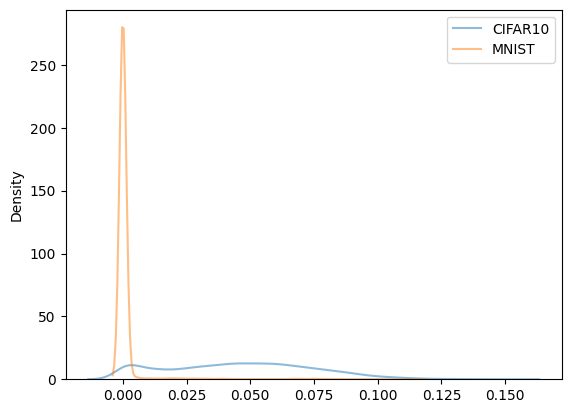

In [10]:
sns.kdeplot(cifar10_uncertainty,alpha=0.5, label='CIFAR10')
sns.kdeplot(mnist_uncertainty,alpha=0.5, label='MNIST')
plt.legend()
plt.show()

In [11]:
mnist_uncertainty.shape, cifar10_uncertainty.shape

(torch.Size([10000]), torch.Size([10000]))

In [12]:
# statistical test for comparing the two distributions
statistic, p_value = ttest_ind(mnist_uncertainty, cifar10_uncertainty)

print("Statistic:", statistic)
print("P-value:", p_value)



Statistic: -148.6778425694965
P-value: 0.0


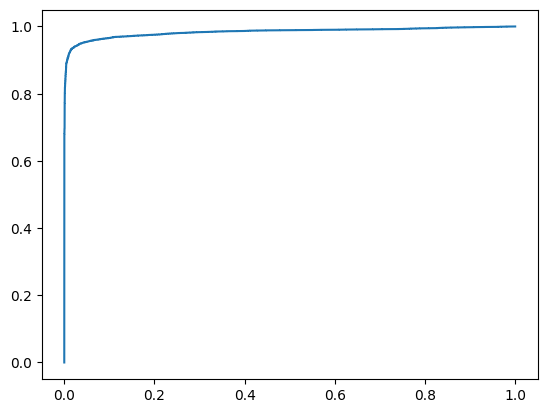

In [13]:

fpr,tpr, thresholds = roc_curve(np.concatenate((np.zeros_like(cifar10_uncertainty),np.ones_like(mnist_uncertainty))),np.concatenate(( -cifar10_uncertainty, -mnist_uncertainty)))
plt.plot(fpr, tpr)


In [14]:
print('AUC:', auc(fpr,tpr))

AUC: 0.98372299
